# AM207 Final Project
**Karina Huang, Lipika Ramaswamy, Erin Williams**

---


In [1]:
# import packages
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import chain
from tqdm import tqdm_notebook as tqdm
from tqdm import trange

## Introduction

This notebook demonstrates our implementation of the work by [Klys et al.](http://papers.nips.cc/paper/7880-learning-latent-subspaces-in-variational-autoencoders), _Learning Latent Subspaces in Variational Autoencoders (VAE)_. In particular, we compared the performance of regular VAE, conditional VAE (CVAE), and conditional subspace VAE (CSVAE) using the classic swiss roll dataset.

<u>**Regular VAE**
![VAE](images/vae.png)

**Conditional VAE**
![Conditional VAE](images/cvae.png)

**Conditional Subspace VAE**</u>
![CSVAE](images/csvae.png)
 

A summary of our project may be found below; our full repository is available on [GitHub](https://github.com/kareenaaahuang/am207_final_project). For detailed implementations of each variation of VAE, please refer to notebooks `vae_swiss_roll.ipynb`,`cvae_swiss_roll.ipynb`,`csvae_swiss_roll.ipynb` in `notebooks/`.

----

## Paper Overview

### Problem Statement 
*Learning Latent Subspaces on Variations Autoencoders* aims to provide a more interpretable Variational Autoencoder (VAE). VAEs are a family of generative models the reduce high-dimensional data to low dimensional data, and then decodes data in the low-dimensional format to generate reasonable outputs. This paper aims to create a VAE which can extract features correlated to binary labels on the data, and structuing it in a latent subspace that is easy to interpret. This is referred to as a Conditional Subspace VAE (CSVAE).  
  
  There are two goals in exploring and implementing a CSVAE:
  1. Learn higher-dimensional latent features correlated with binary labels in the data.
  2. Represent these features using a subspace that is easy to interpret and manipulate when generating or modifying data.
  
### Context/Scope 
  
  Generative models can easily model many complex, high-dimensional data. However, it is currently not possible to isolate a specific feature of interest in an unsupervised manner. CSVAEs aim to make this possible by separating the information correlated with the feature label into a predefined, low-dimensional subspace. Once implemented, this allows for the feature of interest to be manipulated easily, giving the user more ability to customize the data being generated.
  
### Existing Work</br>    
  Kingma and Welling's 2013 [paper](https://arxiv.org/abs/1312.6114) *Auto-Encoding Variational Bayes* set the foundation for VAEs by proving that reparameterization of the variational lower bound yields a lower bound estimator that can be straightforwardly optimized using standard stochastic gradient methods. It also proves that posterior inference can be made especially efficient by fitting an approximate inference model to the intractable posterior using the proposed lower bound estimator (for independent and identically distributed datasets with continuous latent variables per datapoint). It is one of several works that explores various ways to structure the latent space.</br>  
  </br>  
  Many other works have explored how to make the best use of feature labels. Some directly define the labels as latent variables in the model, but fail to create an interpretable structure for these labels. Other methods explored include batching data according to labels and use of discriminator networks. Unfortunately, all these approaches fail to create an interpretable structure for these labels.</br>  
  </br>   
  [Cresswell, et al.](https://arxiv.org/abs/1711.05175v1), explored the minimization of mututal information between a VAE's latent space and feature labels in *Conditional Autoencoders with Adversarial Information Factorization*. This technique was used in the creation of the CSVAE, as mutual information was minimized between certain latent variables. </br>  
  </br>  
  There is also work on attribute transfer, but it relies on interpolating between existing images vice generating a specific attribute by calling on features of interest within the subspace. </br>  
   
### Contribution</br>   
  CSVAEs aim to learn features correlated with data labels. The most immediate utility lies in the task of attribute manipulation. Since subspaces $W_i$ are low-dimensional, we can explicitly visualize the posterior for the corresponding attribute. 
  
### Technical Content (High Level)
  In a simple VAE, the data is encoded and decoded in a latent space. In a Conditional VAE, data is encoded using an original label which is one-hot-encoded. That label is switched and then decoded. The changed label can be scaled to varying intensities.</br>   
  </br>  
  In a CSVAE, this is taken a step farther. We consider $p = (p_1,...p_k) \in \prod_{i=1}^k W_i$ be any vector with $p_l = \vec{0}$ for $l\neq j$. For $(x,y)\in D$: </br>  
  </br>  
  \begin{aligned}
  G_{ij}(x,p) = \mu_{\theta}(\mu_{\phi_1} (x), p) 
  \end{aligned}
 
  Thus, we encode the data into a subspace $Z$, select any point $p$ on $W$, and then decode the concatenated vector. Because $W_i$ is so high dimensional, we have enhanced freedom of attribute manipulation.

### Technical Content (Details) </br>  
  Unfortunately, the paper did not provide a full derivation of the CSVAE. In order to better understand the novel method, we spent significant time understanding the likelihood and generative models described by a VAE. Below, we provide the derivation of a VAE.  
  
  1) Maximize Likelihood </br></br>

\begin{aligned}
\left[
\begin{array}
pp_{\theta}(y_n, z_n)\\
p_{\theta}(y_n|z_n)p_{\theta}(z_n)
\end{array}
\right]\\
\end{aligned}

2) Maximize observed $u$

\begin{aligned}
\theta_{\text{MLE}} &= \mathrm{argmax}_{\theta}\; \mathrm{log} \prod \overbrace{\int p_{\theta}(y_n, z_n) dz_n}^{p_{\theta}(y_n)}\\
&= \mathrm{argmax}_{\theta}\; \nabla_{\theta} \sum_n \mathrm{log}\; \mathbb{E}_{p_{\theta}(z_n)} [p_{\theta}(y_n, z_n)]\\
\end{aligned}
However, this presents an issue when we consider the $\log$ term and the $\nabla_{\theta}$ and $\mathbb{E}_{p_{\theta}}$, so we use EM steps:
</br>  
</br>  
\begin{aligned}
&= \mathrm{argmax}_{\theta}\; \sum_n\; \mathrm{log} \int p_{\theta}(y_n|z_n)\frac{p_{\theta}(z_n)}{q(z_n)} q(z_n)d z_n\\
&= \mathrm{argmax}_{\theta}\; \sum_n\; \mathrm{log}\; \mathbb{E}_{q(z_n)}\; \left[\frac{p_{\theta}(y_n|z_n)p_{\theta}(z_n)}{q(z_n)}\right]\\
\end{aligned}
Apply Jensen's inequality, and we get:</br>  
</br>  
\begin{aligned}
&\ge \mathrm{argmax}_{\theta}\; \underbrace{\sum_n\; \mathbb{E}_{q(z_n)}\; \left[\mathrm{log}\left(\frac{p_{\theta}(y_n,z_n)}{q(z_n)}\right)\right]}_{\text{ELBO}(q, \theta)}\\
\end{aligned}

**Maximize the ELBO**
\begin{aligned} 
\theta_{\text{MLE}} &= \underset{\theta, q}{\text{argmax}}\; \text{ELBO}(\theta, q)\\
\end{aligned}
</br>  
*M Step*:
\begin{aligned} 
\underset{\theta}{\text{max}}\; \nabla_{\theta}\; \text{ELBO}(\theta, q^*)\\
\end{aligned}
*E Step*:
\begin{aligned} 
\underset{q}{\text{max}}\; \text{ELBO}(\theta^*, q)\\
\end{aligned}

We use KL divergence to find:
\begin{aligned} 
q^* &= p_{theta^*}(z_n | y_n)\\
\end{aligned}

But finding the closed form of this equation is hard -- so we rely on variational inference. We use the Gaussian family with mean field:

\begin{aligned} 
q(z_n) & = \mathcal{N}(z_n, \mu_n, \Sigma_n)\\
\theta_{\text{MLE}} &= \underset{\theta}{\text{max}}\; \nabla_{\theta}\; \text{ELBO}(\theta, q^*)\\
\end{aligned}
</br>  
*A) Variational Inference*  
Step E:
\begin{aligned}
\mu_n^*, \Sigma_n^* &= \underset{\mu, \sum}{\text{arming}}\; \text{D}_{\text{KL}} [q(z_n)||p_{\theta^*}(z_n|y_n)]\\
&\equiv \underbrace{\underset{\mu, \sum}{\text{argmax}}\; \mathbb{E}_{q_{\mu, \sum}(z_n)} \left[\mathrm{log}\frac{p_{\theta^*}(z_n, y_n)}{q_{\mu_n, \sum_n}(z_n)}\right]}_{\text{ELBO}(\theta^*,q_{\mu_n, \sum_n} )}\\
\end{aligned}
</br>
As you can see, this is the ELBO of $(\theta^*,q_{\mu_n, \sum_n})$

*B) Amortization*  
\begin{aligned}
g_{\phi^*} &= \mu_{\phi^*}(y_n), \Sigma_{\phi^*}(y_n)\\
\phi^* &= \underset{\phi}{\text{argmin}}\; \sum_n\; \text{D}_{\text{KL}}\left[\text{N}(\mu_{\phi^*}(y_n), \Sigma_{\phi^*}(y_n))||p_{\theta^*}(z_n|y_n)\right]\\
\end{aligned}
</br>
Where the term $\phi^*$ comes from $g_{\phi^*}(y_n)$.  
</br>  
\begin{aligned}
&= \underset{\phi}{\text{argmax}} \underbrace{ \sum_n\; \mathbb{E}_{q_{\phi}(z_n)}\left[ \mathrm{log} \frac{p_{\theta^*}(z_n, y_n)}{q_{\phi}(z_n)} \right]}_{\text{ELBO}(\theta^*,q_{\phi} )}\\
\end{aligned}

*C) Joint Training -- do the E & M Steps together!*  
</br>  
\begin{aligned} 
\theta^*, \phi^* &= \underset{\theta, \phi}{\text{argmax}}\;\text{ELBO}(\theta, q_\phi)
\end{aligned}
Use gradient descent:  
</br>  
\begin{aligned}
\nabla_{\theta, \phi} \; \text{ELBO}(\theta, q_\phi) &= \sum_n\; \nabla_{\theta, \phi}\; \mathbb{E}_{q_\phi(z_n)}\;  \left[ \mathrm{log} \frac{p_{\theta^*}(z_n, y_n)}{q_\phi(z_n)}\right]\\
\end{aligned}

</br>
\begin{aligned}
\nabla_{\theta, \phi} \; \text{ELBO}(\theta, q_\phi) &= \sum_n\; \underbrace{ \nabla_{\theta, \phi}\; \mathbb{E}_{q_\phi(z_n)}\;   \mathrm{log} p_{\theta}(y_n|z_n)}_{\text{(1)}}- \underbrace{\nabla_{\theta, \phi}\text{D}_{\text{KL}}\; \left[q_{\phi}(z_n)||\overbrace{p_{\theta}(z_n)}^{\text{Normal prior}\; \mathrm{N}(0,1)}\right]}_{\text{(2)}}\\
\\
\end{aligned}
</br>  
Consider equation (1):
</br>  
\begin{aligned}
\text{(1)}\;  &= \nabla_{\theta, \phi}\; \mathbb{E}\; \mathrm{log}\; p_\theta(y_n|\mu_n+\epsilon\Sigma_n^{\frac{1}{2}})\\
\end{aligned}
</br>  
Suppose we have that:
\begin{aligned}
z_n &\in \mathbb{R}^J\\
\epsilon &\sim \mathcal{N}(0,1)\\
z_n &\sim \mathcal{N}(\mu_n, \Sigma_n)\\
y_n = \theta_1 z_n + \epsilon, \quad   & \epsilon \sim \mathcal{N}(0, \Sigma_{data})\\
\end{aligned}
So, we can say that:
</br>
$$
\begin{aligned}
p(y_n|z_n) &= \nabla_{\theta, \phi} \underset{\epsilon\sim\mathcal{N}(0,1)}{\mathbb{E}}\; \left( \frac{-1}{2} \log \left( 2 \pi |\Sigma_{data}|\right) - \frac{1}{2}(y_n - \hat{y_n})^T \Sigma_{data}^{-1}(y_n - \hat{y_n})\right)\\
\end{aligned}
$$

We use a Monte Carlo simulation to estimate this expectation.
</br>  
And equation (2):
</br>  
\begin{aligned}
\text{(2)}\; &=\frac{1}{2}\sum_{j=1}^{J}\; (1+\mathrm{log} (\sigma_{j}^2 - \mu_j^2 - \sigma_j^2) \\
\end{aligned}
</br>  

<hr/>

We use this approach to derive the equations for the CSVAE provided in the original paper.

### Experiments</br>  
   </br>  
      Initial experiments were performed on the Swiss Roll data set, with further testing on the Toronto Faces Dataset and the CelebA dataset. Specifically, the team created subsets of CelebA using glasses (CelebA-Glasses), facial hair (CelebA-FacialHair), and both (CelebA-GlassesFacialHair) to show that attributes could be independently manipulated. Application on CelebA-Glasses and CelebA-FacialHair proved that CSVAEs generate a larger variety of both attributes than the baseline VAE and Conditional VAE models. Application on the CelebA-GlassesFacialHair dataset proved that CSVAE could be applied to non-mutually exclusive attributes.  </br>  
      
   While the authors claimed to successfully improve accuracy of attribute classifiers on all data, they did not provide any code or repository to provide evidence to this. This remains one of the key shortfalls of this paper. Experiments are described, but not reproduceable due to lack of sufficient evidence.</br>  
   </br>  
   With this in mind, we chose to perform simple experiments on the Swiss Roll dataset. Below, we provide not only the implementation of the CSVAE, but also the results and a comparison to a VAE and a CVAE.
   
### Evalution</br>  
   <b>*Theoretically*</b>, we believe this is a technically sound paper. Unfortunately, the authors failed to provide a lot of evidence to back the concept of a CSVAE. Most notably, they are missing key derivations, sample implementation, and any evidence of their experiments. Since their derivations had huge gaps, we chose to spend a significant amount of time doing a full derivation of the CSVAE (available in our Technical Content (Details) section). 
   In terms of experiments, the authors provide promising results but lack any true evidence that the CSVAE was implemented as described. We chose to focus on a simple experiment on the Swiss Roll data set, so we could show our results very concretely.
   
### Future Work </br>  
Most notably, we recommend that the authors provide documentation of their implementation and experiments. Because their implementation was not made available, it cannot be checked or verified by others in the field. While the results of their experiments seem promising, it is difficult to put much faith in these results without code to back it up. We have provided our implementation and experiments to show the effectiveness of the CSVAE when compared to a VAE and CVAE.

# Implementation

Please note that this notebook only includes the implementation of the CSVAE. We also implemented a VAE, and a Conditional VAE. Those implementations are referenced in our experimental results section, and can be viewed in full in our [GitHub](https://github.com/kareenaaahuang/am207_final_project) repo under `notebooks`. 

We used `pytorch`, along with `numpy`, `itertools`, and `tqdm`, to complete our implementation. We initially attempted to use `autograd` for our implementation, but found that it was not suited to solve this problem with the approach we chose. 

In [2]:
## define neural nets for each model
class EncoderW(nn.Module):
    
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features) + 1 (label)
    Output dimension: 2 (n_dimensions in the latent space)
    '''
    
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, x, y):
        # pass x and y concatenated into the model
        out = self.model(torch.cat((x, y), dim=-1))
        # separate out components - mean and logvar
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:] # mean field assumption 
        # generate samples
        samples = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
        return mu, logvar, samples

class EncoderZ(nn.Module):
    
    '''
    This class transforms the images into a vector in the latent space, Z. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features)
    Output dimension: 2 (n_dimensions in the latent space)
    '''
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, x):
        # pass x into the model
        out = self.model(x)
        # separate out components - mean and logvar
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:]  # mean field assumption 
        # generate samples
        samples = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu 
        return mu, logvar, samples

    
class DecoderX(nn.Module):
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 2 (latent dims from Z) + 2 (latent dims from W)
    Output dimension: 3 dimensions of original data
    '''
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.fcs = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, w, z):
        # pass w and z concatenated into the model
        out = self.fcs(torch.cat((w, z), dim=-1))
        # separate out components - mean and logvar        
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:] 
        # generate samples
        sample = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
        return mu, logvar, sample


class DecoderY(nn.Module):
    
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features) + 1 (label)
    Output dimension: 2 (dimensions in the latent space)
    '''
    def __init__(self, dim_in, n_classes, n_units = 32):
        super().__init__()
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, n_classes))
        ]))

    def forward(self, z):
        # pass z into the model
        linear_output = self.model(z)
        # softmax the output to get probability of class 1
        out = F.softmax(linear_output, dim=-1)
        return out

In [3]:
def KL(mu1, logvar1, mu2, logvar2):
    '''
    Calculates the KL divergence between two gaussians
    See appendix here for a generalized version of this formula: https://arxiv.org/pdf/1312.6114.pdf
    '''
    std1 = torch.exp(0.5 * logvar1)
    std2 = torch.exp(0.5 * logvar2)
    return torch.sum(torch.log(std2) - torch.log(std1) + 0.5 * (torch.exp(logvar1) + (mu1 - mu2) ** 2) / torch.exp(logvar2) - 0.5, dim=-1)

In [4]:
# Generate swiss roll data
X_, _ = sklearn.datasets.make_swiss_roll(n_samples=100000, random_state=207)
X_ = X_.astype(np.float32)
y_ = (X_[:, 1] < 10).astype(np.int32)
print('Swiss roll data has dimensions {}.\nLabels are generated based on the second dimension have dimensions {}.'.format(X_.shape, y_.shape))

Swiss roll data has dimensions (100000, 3).
Labels are generated based on the second dimension have dimensions (100000,).


In [5]:
def run_csvae(beta1 = 20., beta2 = 1., beta3 = 0.2, beta4 = 1000):
    # Initialize all neural networks (nn) defined above
    encoder_w = EncoderW(dim_in=4, dim_out=2) # nn to encode data and labels into 2 dimensions
    encoder_z = EncoderZ(dim_in=3, dim_out=2) # nn to encode data only into 2 dimensions
    decoder_x = DecoderX(dim_in=4, dim_out=3) # nn to decode the sampled vectors from W and Z to generated data
    decoder_y = DecoderY(dim_in=2, n_classes=2) # nn to decode the sampled vector Z to a label
    
    ## define two optimizers for the two components of the loss:
    ## 1. relating to maximizing the elbo 
    optimizer1 = torch.optim.Adam(chain(decoder_x.parameters(),
        encoder_w.parameters(),
        encoder_z.parameters()), lr=1e-3)

    ## 2. relating to learning the approximate posterior
    optimizer2 = torch.optim.Adam(decoder_y.parameters(), lr=1e-3)
    
    # use dataloader to train in batches
    trainloader = torch.utils.data.DataLoader(list(zip(X_, y_)), shuffle=True, batch_size=256)

    # run training cycle
    with trange(20) as t:
        for i in t:
            t.set_description('Epoch %d' % i)
            # training by batch_size
            for x, y in trainloader:

                # FORWARD PASS: 

                # encode x to get mean, log variance, and samples from the latent subspace Z
                mu_z, logvar_z, z = encoder_z(x)
                # encode x and y to get mean, log variance, and samples from the latent subspace W
                mu_w, logvar_w, w = encoder_w(x, y.unsqueeze(-1).float())

                # pass smaples of z and w to get mean, logvar and predictions of x - modelling it as Gaussina
                mu_x, logvar_x, pred_x = decoder_x(w, z)
                # get predicted labels based only on the latent subspace Z
                pred_y = decoder_y(z)

                # define two KL divergences:
                # KL divergence for label 1
                #    We want the latent subspace W for this label to be close to mean 0, var 0.01
                kl1 = KL(mu1=mu_w, logvar1=logvar_w, 
                         mu2 = torch.zeros_like(mu_w), logvar2 = torch.ones_like(logvar_w) * np.log(0.01))
                # KL divergence for label 0
                #    We want the latent subspace W for this label to be close to mean 3, var 0
                kl0 = KL(mu_w, logvar_w, torch.ones_like(mu_w) * 3., torch.ones_like(logvar_w) * np.log(0.01))

                # OPTIMIZATION: 

                # Specified in section 4.1 of http://www.cs.toronto.edu/~zemel/documents/Conditional_Subspace_VAE_all.pdf
                # There are three components: M1, M2, N

                # 1.Optimize the first loss related to maximizing variational lower bound 
                #   on the marginal log likelihood and minimizing mutual information 
                optimizer1.zero_grad()

                loss1 = (beta1 * torch.sum((x - mu_x) ** 2, -1)  ## corresponds to M1
                    + beta2 * torch.where(y == 1, kl1, kl0)  ## corresponds to M1
                    + beta3 * KL(mu_z, logvar_z, torch.zeros_like(mu_z), torch.zeros_like(logvar_z))  ## corresponds to M1
                    + beta4 * torch.sum(pred_y * torch.log(pred_y), -1)).sum()  # corresponds to M2
                
                loss1.backward(retain_graph=True)
                optimizer1.step()

                # 2. Optimize second loss related to learning the approximate posterior
                optimizer2.zero_grad()
                loss2 = (100. * torch.where(y == 1, -torch.log(pred_y[:, 1]), -torch.log(pred_y[:, 0]))).sum()
                loss2.backward()
                optimizer2.step()

                # combine losses for tracking
                loss = loss1 + loss2

            t.set_postfix(loss=loss.item(), y_max=pred_y.max().item(), y_min=pred_y.min().item())
            # print(loss.item()) # uncomment to print loss
            
    return encoder_w, encoder_z, decoder_x, decoder_y

In [6]:
def plot_reconstruction(pred_x,y_ ):
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.scatter(X_[y_ == 0, 0], X_[y_ == 0, 1], X_[y_ == 0, 2], s = 1, c = 'forestgreen', alpha = 0.7, label = 'original data 0')
    ax.scatter(X_[y_ == 1, 0], X_[y_ == 1, 1], X_[y_ == 1, 2], s = 1, c = 'purple', alpha = 0.7, label = 'original data 1')
    ax.view_init(0,30)
    ax.set_title('Original Data'); ax.legend()
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter(pred_x[y_ == 0, 0], pred_x[y_ == 0, 1], pred_x[y_ == 0, 2], s = 1, c = 'forestgreen', alpha = 0.7, label = 'generated data 0')
    ax.scatter(pred_x[y_ == 1, 0], pred_x[y_ == 1, 1], pred_x[y_ == 1, 2], s = 1, c = 'purple', alpha = 0.7, label = 'generated data 1')
    ax.view_init(0,30)
    ax.set_title('Generated Data'); ax.legend()

#     plt.show()

In [7]:
def plot_latent_subspaces(z_, w_, figsize = (15,8)):
    
    fig1 = plt.figure(figsize = figsize)
    plt.subplot(2,2,1)
    plt.scatter(z_[y_ == 0, 0], z_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
    plt.scatter(z_[y_ == 1, 0], z_[y_ == 1, 1], s=1, c='purple', alpha=0.3)
    plt.title('$(Z_1, Z_2)$', fontsize = 15);

    plt.subplot(2,2,2)
    plt.scatter(w_[y_ == 0, 0], w_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
    plt.scatter(w_[y_ == 1, 0], w_[y_ == 1, 1], s=1, c='purple', alpha=0.3)
    plt.title('$(W_1, W_2)$', fontsize = 15);


    plt.subplot(2,2,3)
    plt.scatter(w_[y_ == 0, 0], z_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
    plt.scatter(w_[y_ == 1, 0], z_[y_ == 1, 1], s=1, c='purple', alpha=0.3)
    plt.title('$(W_1, Z_2)$', fontsize = 15);

    plt.subplot(2,2,4)
    plt.scatter(z_[y_ == 0, 0], w_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
    plt.scatter(z_[y_ == 1, 0], w_[y_ == 1, 1], s=1, c='purple', alpha=0.3)
    plt.title('$(Z_1, W_2)$', fontsize = 15);


## Experiments

#### Data

100,000 swiss roll data points were made for the CSVAE experiment using `make_swiss_roll` from `sklearn.datasets`. Note that we reduced the number of data points to 20,000 for VAE and CVAE for clearer visualization of the outputs. We used the random state of 207 for training data, and 101 for test data.

The generated data was 3-dimensional, and was split into 2 classes according to the second dimension (y). Data points were labeled class 0 if y < 10, and 1 otherwise.

#### Training

The VAE and CVAE were trained for 100 epochs, and the CSVAE for 20 epochs. Comparisons between the 3 approaches were made using the generated data after the 20th epoch of training. We trained all models using the Adam optimizer, with an initial learning rate of 0.001.

#### Full experiment using our CSVAE implementation:

In [8]:
encoder_w, encoder_z, decoder_x, decoder_y = run_csvae(beta1 = 20., beta2 = 1., beta3 = 0.2, beta4 = 1000)

Epoch 19: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it, loss=-9.47e+4, y_max=0.607, y_min=0.393]


In [9]:
# Data Generation Process
with torch.no_grad():
    z_, _, _ = encoder_z(torch.from_numpy(X_))
    w_, _, _ = encoder_w(torch.from_numpy(X_), torch.from_numpy(y_).unsqueeze(-1).float())
    pred_x, _, _ = decoder_x(w_, z_)
    pred_y = decoder_y(z_)
    pred_x = pred_x.cpu().numpy()
    pred_y = pred_y.cpu().numpy()    

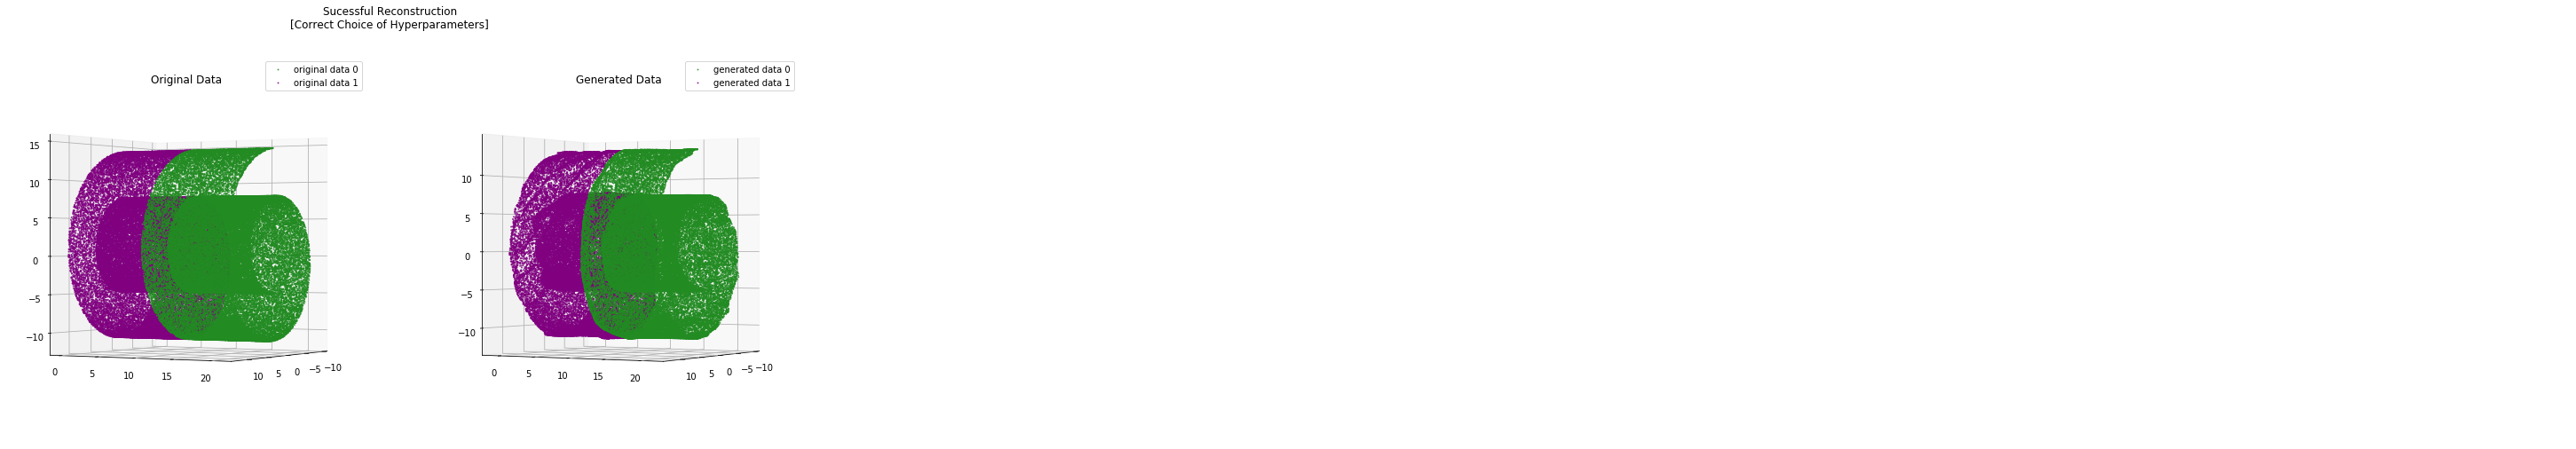

In [10]:
plot_reconstruction(pred_x,y_ )
plt.suptitle('Sucessful Reconstruction\n[Correct Choice of Hyperparameters]')
plt.show()

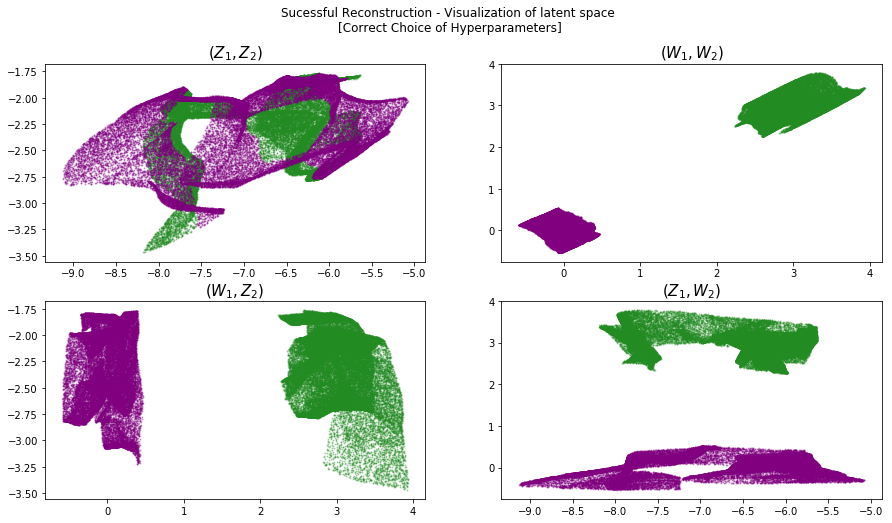

In [11]:
plot_latent_subspaces(z_, w_)
plt.suptitle('Sucessful Reconstruction - Visualization of latent space \n[Correct Choice of Hyperparameters]')
plt.show()

In [12]:
encoder_w_failure, encoder_z_failure, decoder_x_failure, decoder_y_failure = run_csvae(
    beta1 = 20., beta2 = 1., beta3 = 2000, beta4 = 1000)

Epoch 19: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it, loss=-6.62e+4, y_max=0.524, y_min=0.476]


In [13]:
# Data Generation Process
with torch.no_grad():
    z_f, _, _ = encoder_z_failure(torch.from_numpy(X_))
    w_f, _, _ = encoder_w_failure(torch.from_numpy(X_), torch.from_numpy(y_).unsqueeze(-1).float())
    pred_x_f, _, _ = decoder_x_failure(w_, z_)
    pred_y_f = decoder_y_failure(z_)
    pred_x_f = pred_x_f.cpu().numpy()
    pred_y_f = pred_y_f.cpu().numpy()    

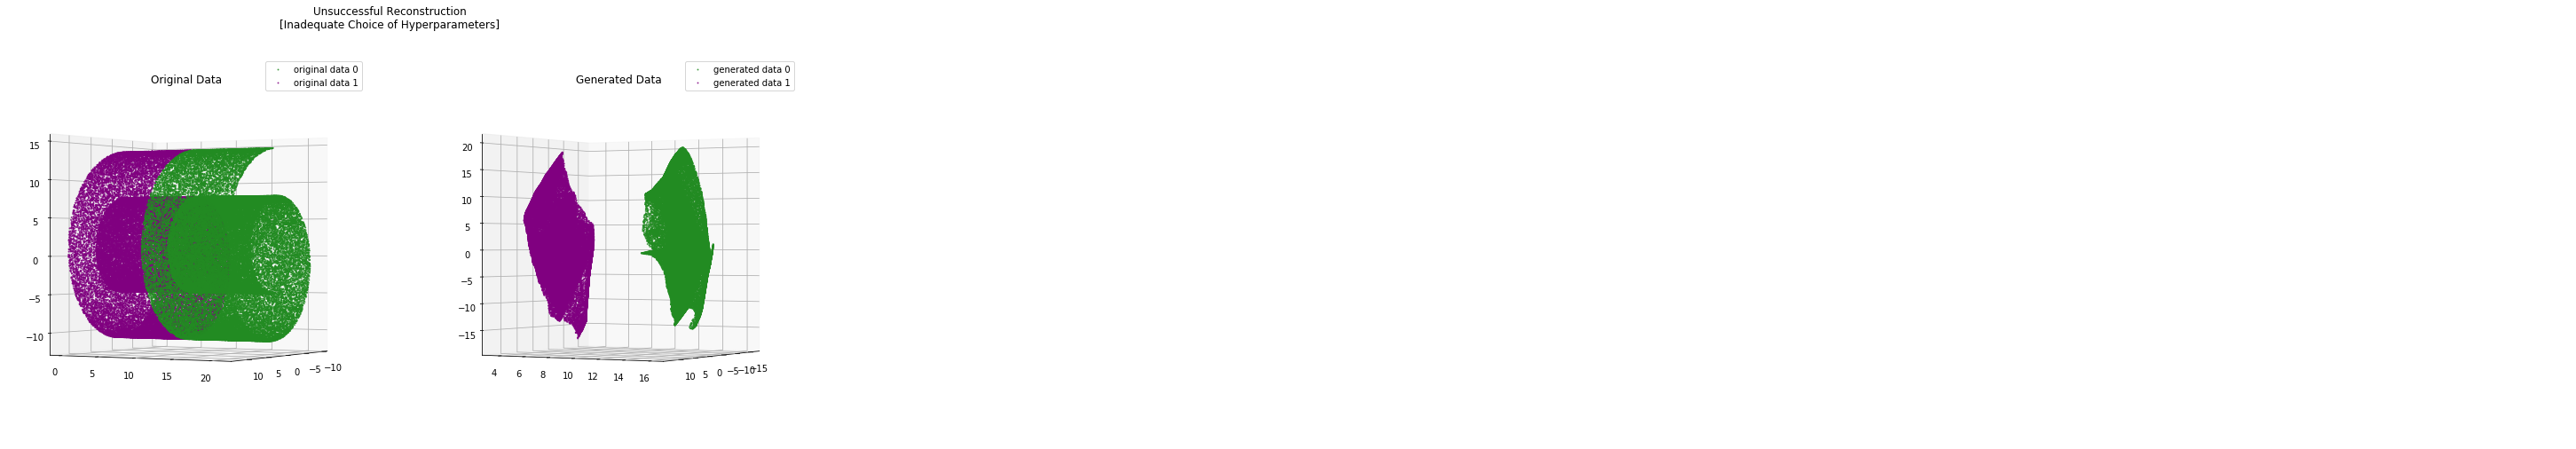

In [14]:
plot_reconstruction(pred_x_f,y_ )
plt.suptitle('Unsuccessful Reconstruction\n[Inadequate Choice of Hyperparameters]')
plt.show()

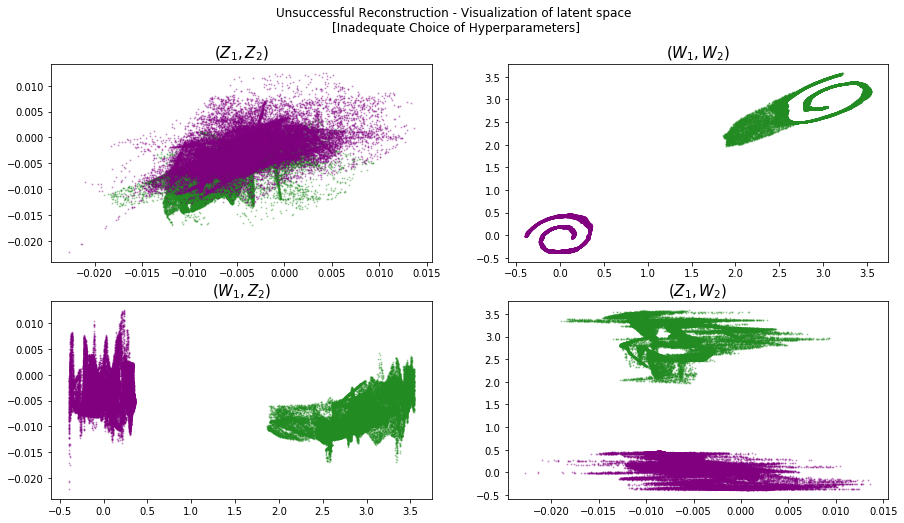

In [15]:
plot_latent_subspaces(z_f, w_f)
plt.suptitle('Unsuccessful Reconstruction - Visualization of latent space \n[Inadequate Choice of Hyperparameters]')
plt.show()

## Results -- Comparison Between VAE, CVAE, and CSVAE

**VAE - Epoch 20**  
[VAE Notebook](https://github.com/kareenaaahuang/am207_final_project/blob/master/notebooks/vae_swiss_roll.ipynb)
![VAE](images/vae_epoch20.png)
_*Note that the generated data is not colored by label as the model does not take labels into account._

**CVAE - Epoch 20**  
[CVAE Notebook](https://github.com/kareenaaahuang/am207_final_project/blob/master/notebooks/cvae_swiss_roll.ipynb)
![CVAE](images/cvae_epoch20.png)

**CSVAE - Epoch 20**
![CSVAE](images/csvae_epoch20.png)

Comparing the 3 models, we observed that CSVAE clearly had outperformed the other 2 models. Interestingly, while CVAE modeled the shape of the data better than the regular VAE, its reconstructed data extended outside the range of the actual data, an observation that did not occur in the regular VAE training progress. CSVAE was able to reconstruct the swiss-roll shape and distinguish between all 3 dimensions, which both other models failed to do at epoch 30th. However, we observed that the performance of CSVAE is dependent upon proper initialization for the weights of the loss function.


## Conclusion

We were able to successfully derive, implement, and run experiments on the CSVAE. We confirmed the model was theoretically sound, and used the `pytorch` library to create an implementation that can be viewed and confirmed by others in the field. For future work, we propose working toward a successful experiment with a dataset such as the Toronto Faces dataset or the CelebA dataset. Both datasets were used in experiments by the authors, but those experiments are not publicly available. 

---